Garbage Classification System combining MobileNetV3 and DistillBert

In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import os
import matplotlib.pyplot as plt
import numpy as np
import re
from transformers import DistilBertModel, DistilBertTokenizer
from sklearn.metrics import confusion_matrix
import seaborn as sns

c:\Users\wjycn\anaconda3\envs\ML\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define data directories
data_dir = "C:\\Projects\\School\\garbage_classification\\Data"
train_dir = os.path.join(data_dir, "CVPR_2024_dataset_Train")
val_dir = os.path.join(data_dir, "CVPR_2024_dataset_Val")
test_dir = os.path.join(data_dir, "CVPR_2024_dataset_Test")

In [3]:
# Define image size, mean, and standard deviation used by the pre-trained model
image_size = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define data preprocessing of images
preprocess = {
    "train": transforms.Compose([
        transforms.Resize((image_size, image_size)),
        # data augmentation: random horizontal flip, vertical flip, color jitter, random rotation
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]),
    "val": transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]),
    "test": transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]),
}

# Load datasets for images
image_datasets = {
    "train": datasets.ImageFolder(train_dir, transform=preprocess["train"]),
    "val": datasets.ImageFolder(val_dir, transform=preprocess["val"]),
    "test": datasets.ImageFolder(test_dir, transform=preprocess["test"]),
}


In [4]:
# Extract text from file names as well as labels
def read_text_files_with_labels(path):
    texts = []
    labels = []
    class_folders = sorted(os.listdir(path))  # Assuming class folders are sorted
    label_map = {class_name: idx for idx, class_name in enumerate(class_folders)}

    for class_name in class_folders:
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            file_names = os.listdir(class_path)
            for file_name in file_names:
                file_path = os.path.join(class_path, file_name)
                if os.path.isfile(file_path):
                    file_name_no_ext, _ = os.path.splitext(file_name)
                    text = file_name_no_ext.replace('_', ' ')
                    text_without_digits = re.sub(r'\d+', '', text)
                    texts.append(text_without_digits)
                    labels.append(label_map[class_name])

    return np.array(texts), np.array(labels)

# Define dataset class for text data
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }
    

# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Read text data
text_train,labels_train = read_text_files_with_labels(train_dir)
text_val,labels_val = read_text_files_with_labels(val_dir)
text_test,labels_test = read_text_files_with_labels(test_dir)

# Tokenize data for text data
max_len = 24
text_datasets = {
    "train": CustomDataset(text_train, labels_train, tokenizer, max_len),
    "val": CustomDataset(text_val, labels_val, tokenizer, max_len),
    "test": CustomDataset(text_test, labels_test, tokenizer, max_len),
}

In [5]:
# Define combined dataset class
class CombinedDataset(Dataset):
    def __init__(self, text_dataset, image_dataset):
        self.text_dataset = text_dataset
        self.image_dataset = image_dataset

    def __len__(self):
        return min(len(self.text_dataset), len(self.image_dataset))

    def __getitem__(self, idx):
        text_data = self.text_dataset[idx]
        image_data = self.image_dataset[idx]

        return {
            'input_ids': text_data['input_ids'],
            'attention_mask': text_data['attention_mask'],
            'label': text_data['label'],
            'image': image_data[0]
        }
    
# Define the combined datasets
combined_datasets = {
    "train": CombinedDataset(text_datasets["train"], image_datasets["train"]),
    "val": CombinedDataset(text_datasets["val"], image_datasets["val"]),
    "test": CombinedDataset(text_datasets["test"], image_datasets["test"]),
}

# Define the dataloaders
dataloaders = {
    "train": DataLoader(combined_datasets["train"], batch_size=32, shuffle=True),
    "val": DataLoader(combined_datasets["val"], batch_size=32, shuffle=False),
    "test": DataLoader(combined_datasets["test"], batch_size=32, shuffle=False),
}

In [6]:
# Define mobilenet model
mobilenet = models.mobilenet_v3_large(pretrained=True)

# Freeze all layers except the last classifier
for param in mobilenet.features.parameters():
    param.requires_grad = False
mobilenet.classifier[3] = nn.Linear(mobilenet.classifier[3].in_features, mobilenet.classifier[3].in_features)

print(mobilenet)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

c:\Users\wjycn\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\wjycn\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# load the distilbert model
distillbert = DistilBertModel.from_pretrained('distilbert-base-uncased')

print(distillbert)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [8]:
# Define the combined model
class CombinedModel(nn.Module):
    def __init__(self, model_mobilenet, model_distilbert, num_classes):
        super(CombinedModel, self).__init__()
        self.model_mobilenet = model_mobilenet
        self.model_distilbert = model_distilbert
        # fully connected layer that takes combined features as input
        self.fc = nn.Linear(model_mobilenet.classifier[3].out_features + model_distilbert.config.hidden_size, num_classes)

    def forward(self, images, input_ids, attention_mask):
        mobilenet_features = self.model_mobilenet(images)
        distilbert_features = self.model_distilbert(input_ids, attention_mask)

        distilbert_features = distilbert_features.last_hidden_state[:, 0, :]
        features = torch.cat((mobilenet_features, distilbert_features), dim=1)
        output = self.fc(features)

        return output

In [9]:
# Instantiate the combined model
num_classes = 4
combined_model = CombinedModel(mobilenet, distillbert, num_classes)

print(combined_model)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
combined_model = combined_model.to(device)

CombinedModel(
  (model_mobilenet): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNor

In [10]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(combined_model.fc.parameters(), lr=0.001)

In [11]:
# Define train function
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for data in dataloader:
        images = data['image'].to(device)
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['label'].to(device)

        optimizer.zero_grad()
        outputs = model(images, input_ids, attention_mask)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc

In [12]:
# define validation function
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for data in dataloader:
            images = data['image'].to(device)
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            labels = data['label'].to(device)

            outputs = model(images, input_ids, attention_mask)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc

In [13]:
# Define predict function
def predict(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in dataloader:
            images = data['image'].to(device)
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            labels = data['label'].to(device)

            outputs = model(images, input_ids, attention_mask)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

In [14]:
# Train and valiadate the model
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(combined_model, dataloaders["train"], criterion, optimizer, device)
    val_loss, val_acc = validate(combined_model, dataloaders["val"], criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

Epoch 1/10, Train Loss: 0.7001, Train Acc: 0.7411, Val Loss: 0.4892, Val Acc: 0.8222
Epoch 2/10, Train Loss: 0.4968, Train Acc: 0.8179, Val Loss: 0.4296, Val Acc: 0.8333
Epoch 3/10, Train Loss: 0.4443, Train Acc: 0.8356, Val Loss: 0.3915, Val Acc: 0.8539
Epoch 4/10, Train Loss: 0.4216, Train Acc: 0.8419, Val Loss: 0.3807, Val Acc: 0.8528
Epoch 5/10, Train Loss: 0.4017, Train Acc: 0.8512, Val Loss: 0.3611, Val Acc: 0.8667
Epoch 6/10, Train Loss: 0.3896, Train Acc: 0.8520, Val Loss: 0.3706, Val Acc: 0.8628
Epoch 7/10, Train Loss: 0.3775, Train Acc: 0.8594, Val Loss: 0.3604, Val Acc: 0.8711
Epoch 8/10, Train Loss: 0.3696, Train Acc: 0.8622, Val Loss: 0.3440, Val Acc: 0.8717
Epoch 9/10, Train Loss: 0.3741, Train Acc: 0.8588, Val Loss: 0.3403, Val Acc: 0.8767
Epoch 10/10, Train Loss: 0.3639, Train Acc: 0.8633, Val Loss: 0.3350, Val Acc: 0.8833


Test Accuracy: 0.7995
Correct: 2744, Total: 3432


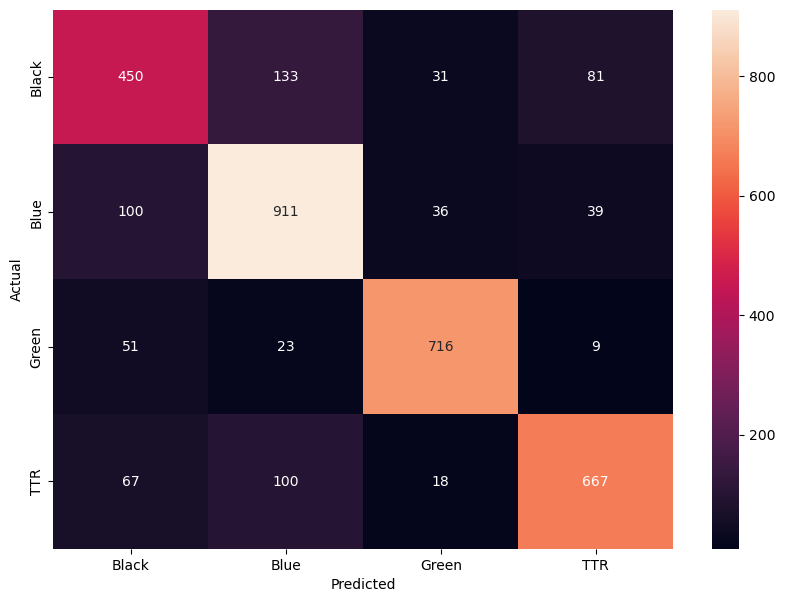

In [16]:
# Test the model
preds, labels = predict(combined_model, dataloaders["test"], device)

# Test accuracy
correct = np.sum(np.array(preds) == np.array(labels))
total = len(labels)
accuracy = correct / total
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Correct: {correct}, Total: {total}')

# Calculate confusion matrix
cm = confusion_matrix(labels, preds)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=image_datasets["test"].classes, yticklabels=image_datasets["test"].classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()